<a href="https://colab.research.google.com/github/saadam1n/CS4803-EML/blob/main/lab0/lab0_task2_Saad_Amin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pleas read:

before your start running this jupyter notebook, please click Edit > Notebook Settings and choose any of the available GPUs.

## 0. Import Python Packages

In [1]:
%pip install thop

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: you may import more packages below:
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import tqdm

import matplotlib.pyplot as plt

from torch.profiler import profile, ProfilerActivity, record_function
import torch.cuda.profiler as profiler

from thop import profile

# get rid of annoying log messages from thop
import logging
logging.getLogger("ptflops").setLevel(logging.WARNING)

## 1. Define your first network

In [3]:
# ResNet Block
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.silu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = out + self.shortcut(x)
        out = F.silu(out)
        return out

# there is a paper out there called poolformer
class PoolFormerBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(PoolFormerBlock, self).__init__()

        self.pooler = nn.Sequential(
            nn.BatchNorm2d(in_planes),
            nn.MaxPool2d(kernel_size=3, stride=stride, padding=1)
        )

        self.ffn = nn.Sequential(
            nn.BatchNorm2d(in_planes),
            nn.Conv2d(in_planes, planes * 2, kernel_size=1, stride=1, bias=False),
            nn.SiLU(),
            nn.Conv2d(planes * 2, planes, kernel_size=1, stride=1, bias=False)
        )

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.BatchNorm2d(in_planes),
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=1, bias=False),
            )

    def forward(self, x):
        out = self.pooler(x) + x
        out = self.ffn(out) + self.shortcut(out)

        return out


# ResNet Model
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        # we utilize lazy in places to make it compatible with both CIFAR and MNIST

        self.conv1 = nn.LazyConv2d(64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.LazyLinear(num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

## 2. Implement training loop and test function

In [4]:
# I put in quite a bit of extra stuff to profile/optimizing training
# since I have an interview coming where I need to do that

def train(model, device, train_loader, optimizer, scheduler, epoch, compile_mode):
    model.train()

    if compile_mode is not None:
        model.compile(compile_mode)

    running_loss = 0.0
    correct = 0
    total = 0
    loss_curve = []

    scaler = torch.amp.GradScaler("cuda")

    print_acc = False

    for epoch in tqdm.tqdm(range(epoch)):
      for batch_idx, (data, target) in enumerate(train_loader):
          data, target = data.to(device), target.to(device)

          optimizer.zero_grad()

          with torch.autocast(device_type="cuda", dtype=torch.float16):
              output = model(data)
              loss = F.cross_entropy(output, target)

          scaler.scale(loss).backward()

          scaler.step(optimizer)
          scaler.update()

          running_loss += loss.item()

          if batch_idx % 100 == 0:
              loss_curve.append(loss.item())

              if print_acc:
                _, predicted = output.max(1)
                total += target.size(0)
                correct += predicted.eq(target).sum().item()

                print(f'Batch {batch_idx}, Loss: {loss.item():.4f}, Acc: {100.*correct/total:.2f}%')

      scheduler.step()



    return loss_curve

def test(model, device, test_loader, compile_mode):
    # TODO: finish this function, you are required to:
    # 1. print the loss and classification accuracy on the test set
    with torch.no_grad():
      model.eval()

      # This should force recompilation from training... I think
      if compile_mode is not None:
          model.compile(mode=compile_mode)

      running_loss = 0.0

      correct = 0
      total = 0

      total_latency = 0.0
      macs = 0

      for batch_idx, (data, target) in enumerate(test_loader):
          data, target = data.to(device), target.to(device)

          start = torch.cuda.Event(enable_timing=True)
          end = torch.cuda.Event(enable_timing=True)

          with torch.autocast(device_type="cuda", dtype=torch.float16):
            # torch.compile warmup before collecting timing data
            if compile_mode is not None and batch_idx == 0:
              print("Warming up for torch.compile()...")
              for _ in range(3):
                  _ = model(data)

            start.record()
            output = model(data)
            end.record()

            loss = F.cross_entropy(output, target)

            if batch_idx == 0:
              # get a batch size of 1
              macs, params = profile(model, inputs=(data[:1], ), verbose=False)

          _, predicted = output.max(1)
          total += target.size(0)
          correct += predicted.eq(target).sum().item()

          running_loss += loss.item()

          # Measure latency
          torch.cuda.synchronize()
          total_latency += start.elapsed_time(end)

      print(f'Loss: {running_loss / len(test_loader):.4f}, Acc: {100.*correct/total:.2f}%, Latency: {total_latency / len(test_loader):.2f}ms, MACs: {macs / 1000000:.1f}M')


## 3. Dataset loading


In [5]:
# TODO: finish the code here, you are required to:
# 1. load the training and testing split of the MNIST dataset

load_mnist = False

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

mnist_train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
mnist_test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Data transforms
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Dataset and DataLoader
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                              download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform_test)

cifar_train_loader = DataLoader(train_dataset, batch_size=384, shuffle=True, pin_memory=True)
cifar_test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, pin_memory=True)




## 4. Put Everything Together

MNIST: Loss: 0.0178, Acc: 99.54%

CIFAR: Loss: 0.4036, Acc: 87.25%

RUNNING TRAINING AND TESTING FOR BASE CONFIG DATASET:MNIST


100%|██████████| 4/4 [01:28<00:00, 22.05s/it]


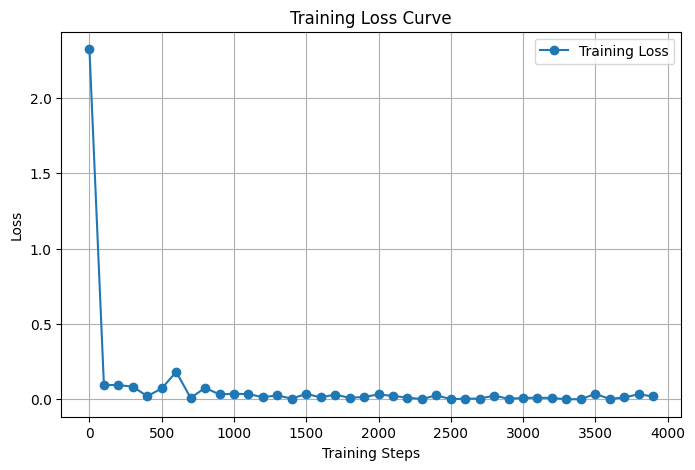

Loss: 0.0182, Acc: 99.42%, Latency: 3.26ms, MACs: 457.7M
FINISHED TRAINING AND TESTING FOR BASE CONFIG DATASET:MNIST




RUNNING TRAINING AND TESTING FOR BASE CONFIG DATASET:CIFAR-10


100%|██████████| 12/12 [04:22<00:00, 21.91s/it]


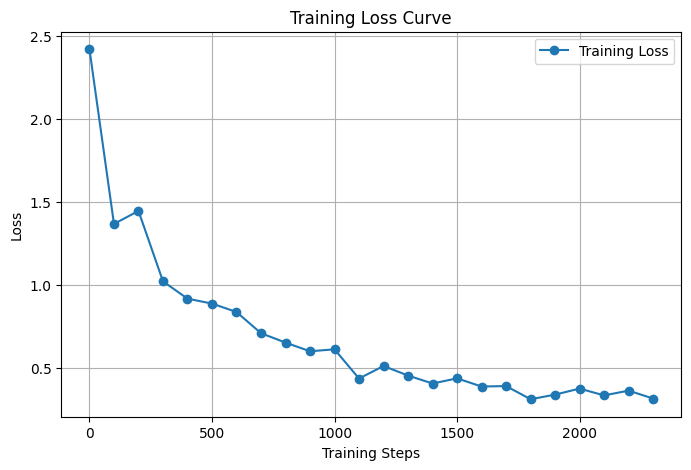

Loss: 0.4294, Acc: 85.92%, Latency: 3.32ms, MACs: 557.9M
FINISHED TRAINING AND TESTING FOR BASE CONFIG DATASET:CIFAR-10




The models meeting the accuracy requirements of this assignment are above.
What follows is an automated ablation study. Graphs are not shown to clean up clutter.
RUNNING TRAINING AND TESTING FOR DATASET:MNIST LR:0.0001


100%|██████████| 2/2 [00:43<00:00, 21.70s/it]


Loss: 0.0494, Acc: 98.49%, Latency: 2.99ms, MACs: 457.7M
FINISHED TRAINING AND TESTING FOR DATASET:MNIST LR:0.0001




RUNNING TRAINING AND TESTING FOR DATASET:MNIST LR:0.001


100%|██████████| 2/2 [00:43<00:00, 21.65s/it]


Loss: 0.0372, Acc: 98.81%, Latency: 2.98ms, MACs: 457.7M
FINISHED TRAINING AND TESTING FOR DATASET:MNIST LR:0.001




RUNNING TRAINING AND TESTING FOR DATASET:MNIST LR:0.01


100%|██████████| 2/2 [00:43<00:00, 21.57s/it]


Loss: 0.0317, Acc: 99.08%, Latency: 2.99ms, MACs: 457.7M
FINISHED TRAINING AND TESTING FOR DATASET:MNIST LR:0.01




RUNNING TRAINING AND TESTING FOR DATASET:MNIST LR:0.1


100%|██████████| 2/2 [00:43<00:00, 21.77s/it]


Loss: 0.0904, Acc: 97.62%, Latency: 3.01ms, MACs: 457.7M
FINISHED TRAINING AND TESTING FOR DATASET:MNIST LR:0.1




RUNNING TRAINING AND TESTING FOR DATASET:MNIST OPTIMZER:SGD


100%|██████████| 2/2 [00:41<00:00, 20.95s/it]


Loss: 0.1407, Acc: 97.02%, Latency: 3.00ms, MACs: 457.7M
FINISHED TRAINING AND TESTING FOR DATASET:MNIST OPTIMZER:SGD




RUNNING TRAINING AND TESTING FOR DATASET:MNIST OPTIMZER:Adam


100%|██████████| 2/2 [00:43<00:00, 21.71s/it]


Loss: 0.0373, Acc: 98.76%, Latency: 3.01ms, MACs: 457.7M
FINISHED TRAINING AND TESTING FOR DATASET:MNIST OPTIMZER:Adam




RUNNING TRAINING AND TESTING FOR DATASET:MNIST OPTIMZER:AdamW


100%|██████████| 2/2 [00:43<00:00, 21.68s/it]


Loss: 0.0296, Acc: 98.95%, Latency: 3.04ms, MACs: 457.7M
FINISHED TRAINING AND TESTING FOR DATASET:MNIST OPTIMZER:AdamW




RUNNING TRAINING AND TESTING FOR DATASET:MNIST OPTIMZER:RMSProp


100%|██████████| 2/2 [00:43<00:00, 21.83s/it]


Loss: 0.0610, Acc: 98.19%, Latency: 3.01ms, MACs: 457.7M
FINISHED TRAINING AND TESTING FOR DATASET:MNIST OPTIMZER:RMSProp




RUNNING TRAINING AND TESTING FOR DATASET:MNIST SCHEDULER:StepLR


100%|██████████| 2/2 [00:43<00:00, 21.71s/it]


Loss: 0.0373, Acc: 98.86%, Latency: 3.00ms, MACs: 457.7M
FINISHED TRAINING AND TESTING FOR DATASET:MNIST SCHEDULER:StepLR




RUNNING TRAINING AND TESTING FOR DATASET:MNIST SCHEDULER:ExponentialLR


100%|██████████| 2/2 [00:43<00:00, 21.77s/it]


Loss: 0.0366, Acc: 98.82%, Latency: 3.15ms, MACs: 457.7M
FINISHED TRAINING AND TESTING FOR DATASET:MNIST SCHEDULER:ExponentialLR




RUNNING TRAINING AND TESTING FOR DATASET:MNIST SCHEDULER:CosineAnnealingLR


100%|██████████| 2/2 [00:43<00:00, 21.79s/it]


Loss: 0.0301, Acc: 99.09%, Latency: 3.00ms, MACs: 457.7M
FINISHED TRAINING AND TESTING FOR DATASET:MNIST SCHEDULER:CosineAnnealingLR




RUNNING TRAINING AND TESTING FOR DATASET:CIFAR-10 LR:0.0001


100%|██████████| 8/8 [02:57<00:00, 22.20s/it]


Loss: 0.5787, Acc: 80.02%, Latency: 3.01ms, MACs: 557.9M
FINISHED TRAINING AND TESTING FOR DATASET:CIFAR-10 LR:0.0001




RUNNING TRAINING AND TESTING FOR DATASET:CIFAR-10 LR:0.001


100%|██████████| 8/8 [02:57<00:00, 22.20s/it]


Loss: 0.5285, Acc: 82.73%, Latency: 3.08ms, MACs: 557.9M
FINISHED TRAINING AND TESTING FOR DATASET:CIFAR-10 LR:0.001




RUNNING TRAINING AND TESTING FOR DATASET:CIFAR-10 LR:0.01


100%|██████████| 8/8 [02:56<00:00, 22.12s/it]


Loss: 0.7964, Acc: 73.08%, Latency: 2.97ms, MACs: 557.9M
FINISHED TRAINING AND TESTING FOR DATASET:CIFAR-10 LR:0.01




RUNNING TRAINING AND TESTING FOR DATASET:CIFAR-10 LR:0.1


100%|██████████| 8/8 [02:56<00:00, 22.09s/it]


Loss: 1.0473, Acc: 63.15%, Latency: 2.92ms, MACs: 557.9M
FINISHED TRAINING AND TESTING FOR DATASET:CIFAR-10 LR:0.1




RUNNING TRAINING AND TESTING FOR DATASET:CIFAR-10 OPTIMZER:SGD


100%|██████████| 8/8 [02:55<00:00, 21.97s/it]


Loss: 1.7602, Acc: 35.07%, Latency: 3.15ms, MACs: 557.9M
FINISHED TRAINING AND TESTING FOR DATASET:CIFAR-10 OPTIMZER:SGD




RUNNING TRAINING AND TESTING FOR DATASET:CIFAR-10 OPTIMZER:Adam


100%|██████████| 8/8 [02:56<00:00, 22.10s/it]


Loss: 0.4874, Acc: 83.29%, Latency: 2.97ms, MACs: 557.9M
FINISHED TRAINING AND TESTING FOR DATASET:CIFAR-10 OPTIMZER:Adam




RUNNING TRAINING AND TESTING FOR DATASET:CIFAR-10 OPTIMZER:AdamW


100%|██████████| 8/8 [02:57<00:00, 22.16s/it]


Loss: 0.4829, Acc: 83.82%, Latency: 2.96ms, MACs: 557.9M
FINISHED TRAINING AND TESTING FOR DATASET:CIFAR-10 OPTIMZER:AdamW




RUNNING TRAINING AND TESTING FOR DATASET:CIFAR-10 OPTIMZER:RMSProp


100%|██████████| 8/8 [02:56<00:00, 22.06s/it]


Loss: 0.8177, Acc: 73.27%, Latency: 2.97ms, MACs: 557.9M
FINISHED TRAINING AND TESTING FOR DATASET:CIFAR-10 OPTIMZER:RMSProp




RUNNING TRAINING AND TESTING FOR DATASET:CIFAR-10 SCHEDULER:StepLR


100%|██████████| 8/8 [02:57<00:00, 22.14s/it]


Loss: 0.5066, Acc: 82.74%, Latency: 3.17ms, MACs: 557.9M
FINISHED TRAINING AND TESTING FOR DATASET:CIFAR-10 SCHEDULER:StepLR




RUNNING TRAINING AND TESTING FOR DATASET:CIFAR-10 SCHEDULER:ExponentialLR


100%|██████████| 8/8 [02:58<00:00, 22.26s/it]


Loss: 0.5770, Acc: 81.11%, Latency: 3.00ms, MACs: 557.9M
FINISHED TRAINING AND TESTING FOR DATASET:CIFAR-10 SCHEDULER:ExponentialLR




RUNNING TRAINING AND TESTING FOR DATASET:CIFAR-10 SCHEDULER:CosineAnnealingLR


100%|██████████| 8/8 [02:57<00:00, 22.19s/it]


Loss: 0.4465, Acc: 85.29%, Latency: 3.03ms, MACs: 557.9M
FINISHED TRAINING AND TESTING FOR DATASET:CIFAR-10 SCHEDULER:CosineAnnealingLR




And now we are done!


In [6]:
# TODO: finish the code here, you are required to:
# 1. launch model training: recommended hyperparameter: batch size = 64, learning rate = 1.0, adam optimizer
# 2. visualize the training loss curve using matplotlib or any other libraries

device = torch.device("cuda")
def train_and_test(model, optimizer, scheduler, train_loader, test_loader, num_epochs, display_graph = False):
    model.to(device)

    # disable compilation to make the data collected more understandable
    compile_mode = None

    losses = train(model, device, train_loader, optimizer, scheduler, num_epochs, compile_mode)

    if display_graph:
        steps = [i * 100 for i in range(len(losses))]

        plt.figure(figsize=(8, 5))
        plt.plot(steps, losses, marker='o', label="Training Loss")

        plt.xlabel("Training Steps")
        plt.ylabel("Loss")
        plt.title("Training Loss Curve")
        plt.legend()
        plt.grid(True)
        plt.show()

    # run test
    test(model, device, test_loader, compile_mode)



# idk I am not going to format this neatly
# iterate through various datasets to show that we meet the accuracy baselines

dataset_configs = [("MNIST", mnist_train_loader, mnist_test_loader), ("CIFAR-10", cifar_train_loader, cifar_test_loader)]

for dataset_name, train_loader, test_loader in dataset_configs:
    num_epochs = 12 if dataset_name == "CIFAR-10" else 4

    config_str = f"BASE CONFIG DATASET:{dataset_name}"

    print("===================================================================")
    print(f"RUNNING TRAINING AND TESTING FOR {config_str}")

    model = ResNet18()
    optimizer = optim.Adam(model.parameters(), lr = 0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)

    train_and_test(model, optimizer, scheduler, train_loader, test_loader, num_epochs, True)

    print(f"FINISHED TRAINING AND TESTING FOR {config_str}")
    print("===================================================================")


    print("\n\n\n")

print("The models meeting the accuracy requirements of this assignment are above.")
print("What follows is an automated ablation study. Graphs are not shown to clean up clutter.")

for dataset_name, train_loader, test_loader in dataset_configs:
    # save compute time and my patience
    # this is probably not going to be representative of final conditions
    # but in the real world you don't get that much time anwyays
    num_epochs = 8 if dataset_name == "CIFAR-10" else 2

    # now iterate through some learning rates
    for learning_rate in [0.0001, 0.001, 0.01, 0.1]:
        config_str = f"DATASET:{dataset_name} LR:{learning_rate}"

        print("===================================================================")
        print(f"RUNNING TRAINING AND TESTING FOR {config_str}")

        model = ResNet18()
        optimizer = optim.Adam(model.parameters(), lr = learning_rate)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)

        train_and_test(model, optimizer, scheduler, train_loader, test_loader, num_epochs)

        print(f"FINISHED TRAINING AND TESTING FOR {config_str}")
        print("===================================================================")


        print("\n\n\n")

    # now iterate through some optimizers
    for optim_name, optim_type in [("SGD", optim.SGD), ("Adam", optim.Adam), ("AdamW", optim.AdamW), ("RMSProp", optim.RMSprop)]:
        config_str = f"DATASET:{dataset_name} OPTIMZER:{optim_name}"

        print("===================================================================")
        print(f"RUNNING TRAINING AND TESTING FOR {config_str}")

        model = ResNet18()
        optimizer = optim_type(model.parameters(), lr = 0.001)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)

        train_and_test(model, optimizer, scheduler, train_loader, test_loader, num_epochs)

        print(f"FINISHED TRAINING AND TESTING FOR {config_str}")
        print("===================================================================")


        print("\n\n\n")

    # now iterate through some schedulers
    for scheduler_name, scheduler_type, scheduler_kwargs in [
        ("StepLR", optim.lr_scheduler.StepLR, {"step_size": 1, "gamma": 0.8}),
        ("ExponentialLR", optim.lr_scheduler.ExponentialLR, {"gamma": 0.9}),
        ("CosineAnnealingLR", optim.lr_scheduler.CosineAnnealingLR, {"T_max": 10}),
    ]:
        config_str = f"DATASET:{dataset_name} SCHEDULER:{scheduler_name}"

        print("===================================================================")
        print(f"RUNNING TRAINING AND TESTING FOR {config_str}")

        model = ResNet18()
        optimizer = optim.Adam(model.parameters(), lr = 0.001)
        scheduler = scheduler_type(optimizer, **scheduler_kwargs)

        train_and_test(model, optimizer, scheduler, train_loader, test_loader, num_epochs)

        print(f"FINISHED TRAINING AND TESTING FOR {config_str}")
        print("===================================================================")


        print("\n\n\n")


print("And now we are done!")